In [6]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq langchain_community tiktoken


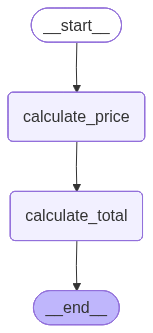

In [7]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    item_count: int
    total_cost: float

class PrivateState(TypedDict):
    item_price: float

def calculate_price(state: OverallState) -> PrivateState:
    print("---Calculating Price---")

    return {"item_price": 10.0}

def calculate_total(state: PrivateState) -> OverallState:
    print("---Calculating Total---")
 
    return {"total_cost": state['item_price'] * 5} 

# Build graph
builder = StateGraph(OverallState)
builder.add_node("calculate_price", calculate_price)
builder.add_node("calculate_total", calculate_total)

# Logic
builder.add_edge(START, "calculate_price")
builder.add_edge("calculate_price", "calculate_total")
builder.add_edge("calculate_total", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"item_count": 5})

---Calculating Price---
---Calculating Total---


{'item_count': 5, 'total_cost': 50.0}

C:\Users\DELL\AppData\Local\Temp\ipykernel_14268\2335615081.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002675C453ED0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: f9ea35af-a88d-4385-9485-e5e8e5361c6a)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-Mini

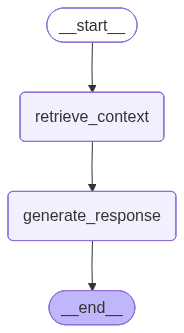

In [12]:
import os
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Set Groq API key
os.environ["GROQ_API_KEY"] = "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"

# Initialize Groq Chat model
llm = ChatGroq(temperature=0, model_name="moonshotai/kimi-k2-instruct")

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

class OverallState(TypedDict):
    query: str
    context: str
    response: str

def retrieve_context(state: OverallState):
    print("---Retrieving Context---")
    
    if "pizza" in state['query'].lower():
        context = "Pizza is an Italian dish consisting of a usually round, flat base of leavened wheat-based dough topped with tomatoes, cheese, and often various other ingredients."
    elif "spaghetti" in state['query'].lower():
        context = "Spaghetti is a long, thin, solid, cylindrical pasta. It is a staple food of traditional Italian cuisine."
    else:
        context = "No specific context found for this query."
    return {"context": context}

def generate_response(state: OverallState):
    print("---Generating Response---")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant. Use the provided context to answer the user's query."),
        ("user", "Context: {context}\nQuery: {query}")
    ])
    chain = prompt | llm | StrOutputParser()

    response = chain.invoke({"context": state['context'], "query": state['query']})
    return {"response": response}

graph = StateGraph(OverallState)
graph.add_node("retrieve_context", retrieve_context)
graph.add_node("generate_response", generate_response)
graph.add_edge(START, "retrieve_context")
graph.add_edge("retrieve_context", "generate_response")
graph.add_edge("generate_response", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"query":"What is pizza?"})

---Retrieving Context---
---Generating Response---


{'query': 'What is pizza?',
 'context': 'Pizza is an Italian dish consisting of a usually round, flat base of leavened wheat-based dough topped with tomatoes, cheese, and often various other ingredients.',
 'response': 'Pizza is an Italian dish made of a usually round, flat base of leavened wheat-based dough topped with tomatoes, cheese, and often various other ingredients.'}

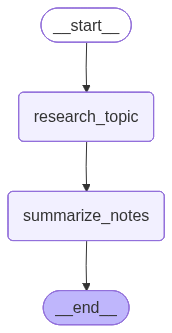

---Researching Topic---
---Summarizing Notes---


{'summary': 'No research notes available on this topic.'}

In [14]:
class InputState(TypedDict):
    topic: str

class OutputState(TypedDict):
    summary: str

class OverallState(TypedDict):
    topic: str
    research_notes: str
    summary: str

def research_topic(state: InputState):
    print("---Researching Topic---")
    # Simulate some research based on the topic
    if state['topic'].lower() == "history of AI":
        notes = "Early AI research focused on problem-solving and symbolic methods. Key milestones include the Dartmouth workshop in 1956 and the development of expert systems."
    elif state['topic'].lower() == "quantum computing basics":
        notes = "Quantum computing uses quantum-mechanical phenomena such as superposition and entanglement to perform computations. Qubits are the basic unit of information."
    else:
        notes = "No specific research notes for this topic."
    return {"research_notes": notes}

def summarize_notes(state: OverallState) -> OutputState:
    print("---Summarizing Notes---")
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Summarize the following research notes concisely."),
        ("user", "Research Notes: {research_notes}")
    ])
    chain = prompt | llm | StrOutputParser()
    summary = chain.invoke({"research_notes": state['research_notes']})
    return {"summary": summary}

graph = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)
graph.add_node("research_topic", research_topic)
graph.add_node("summarize_notes", summarize_notes)
graph.add_edge(START, "research_topic")
graph.add_edge("research_topic", "summarize_notes")
graph.add_edge("summarize_notes", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"topic":"History of AI"})

